# Keras based GNA mnist generating

https://github.com/soumith/ganhacks
https://arxiv.org/pdf/1406.2661.pdf
https://arxiv.org/pdf/1511.06434.pdf

## Setup environment

In [2]:
import sys
import glob
print(sys.version)
print(sys.path)

3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
['', '/home/adam/Developer/kalibr_workspace/devel/lib/python2.7/dist-packages', '/opt/ros/kinetic/lib/python2.7/dist-packages', '/home/adam/miniconda3/envs/keras_gpu_env/lib/python36.zip', '/home/adam/miniconda3/envs/keras_gpu_env/lib/python3.6', '/home/adam/miniconda3/envs/keras_gpu_env/lib/python3.6/lib-dynload', '/home/adam/miniconda3/envs/keras_gpu_env/lib/python3.6/site-packages', '/home/adam/miniconda3/envs/keras_gpu_env/lib/python3.6/site-packages/IPython/extensions', '/home/adam/.ipython']


In [3]:
sys.path.remove('/home/adam/Developer/kalibr_workspace/devel/lib/python2.7/dist-packages')
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

## Include

In [4]:
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU
from keras import optimizers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.models import model_from_json
from keras import initializers
from keras.layers import Input
from keras.models import Model
#K.set_image_dim_ordering('th')

import glob
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
import math
import random
from tqdm import tqdm

Using TensorFlow backend.


## Parameters setup

In [5]:
img_rows, img_cols = 28, 28
channels = 1
input_shape= (img_rows, img_cols, channels)

## Load  Data

In [6]:
mnist_path = '/home/adam/Data/mnist/'

x_train, y_train = loadlocal_mnist(
                images_path=mnist_path+'/train-images.idx3-ubyte', 
                labels_path=mnist_path+'/train-labels.idx1-ubyte'
            )

x_train = x_train.reshape(x_train.shape[0], int(math.sqrt(x_train.shape[1])), int(math.sqrt(x_train.shape[1])))
x_train = (x_train.astype(np.float32) / 128) - 1

In [7]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


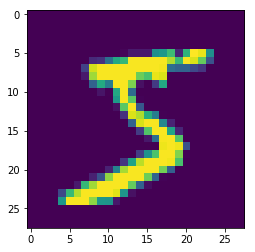

In [8]:
plt.imshow(x_train[0,:,:])
plt.show()

## Model Definition

### Generator

In [9]:
leaky_alpha = 0.2
noise_size = 100

generator = Sequential()
generator.add(Dense(128*7*7, input_dim=noise_size, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(leaky_alpha))

generator.add(Reshape((7, 7, 128)))

generator.add(UpSampling2D(size=(2, 2)))

generator.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
generator.add(LeakyReLU(leaky_alpha))

generator.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
generator.add(LeakyReLU(leaky_alpha))

generator.add(UpSampling2D(size=(2, 2)))

generator.add(Conv2D(16, kernel_size=(3, 3), padding='same'))
generator.add(LeakyReLU(leaky_alpha))

generator.add(Conv2D(1, kernel_size=(3, 3), padding='same', activation='tanh'))

print(generator.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
__________

### Discriminator

In [10]:
leaky_alpha = 0.2
dropout = 0.3

discriminator = Sequential()
discriminator.add(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=(28, 28,1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(leaky_alpha))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
discriminator.add(LeakyReLU(leaky_alpha))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
discriminator.add(LeakyReLU(leaky_alpha))
discriminator.add(Dropout(dropout))

discriminator.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(leaky_alpha))
discriminator.add(Dropout(dropout))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=5e-4, beta_1=0.5))

print(discriminator.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 64)        18496     
__________

### GAN

In [11]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(noise_size,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4, beta_1=0.5))


## Learning Phase

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 1


100%|██████████| 468/468 [00:18<00:00, 25.15it/s]

 D_loss: 0.551657 G_loss: 1.0673287


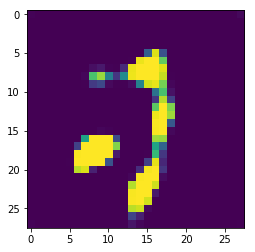

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 2


100%|██████████| 468/468 [00:15<00:00, 30.10it/s]


 D_loss: 0.55661196 G_loss: 0.8782935


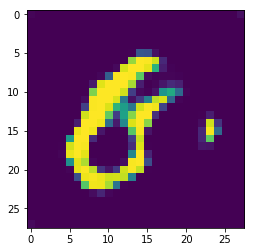

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 3


100%|██████████| 468/468 [00:15<00:00, 30.06it/s]

 D_loss: 0.57642007 G_loss: 0.97284204


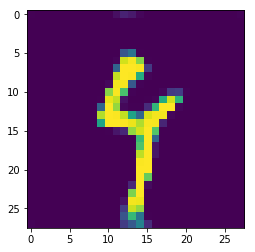

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 4


100%|██████████| 468/468 [00:15<00:00, 30.08it/s]

 D_loss: 0.6156702 G_loss: 0.8738287


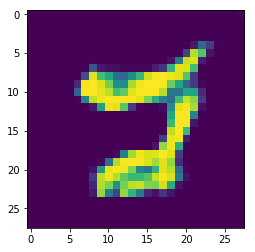

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 5


100%|██████████| 468/468 [00:15<00:00, 30.08it/s]


 D_loss: 0.602261 G_loss: 0.98702955


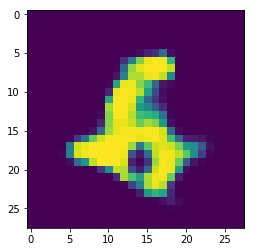

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 6


100%|██████████| 468/468 [00:15<00:00, 30.09it/s]

 D_loss: 0.6379646 G_loss: 0.9506896


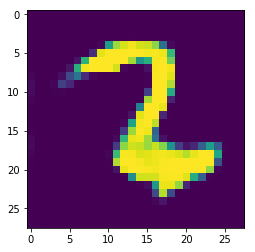

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 7


100%|██████████| 468/468 [00:15<00:00, 30.08it/s]


 D_loss: 0.5962955 G_loss: 0.8288239


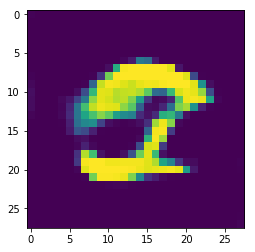

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 8


100%|██████████| 468/468 [00:15<00:00, 30.11it/s]


 D_loss: 0.62699914 G_loss: 0.87706316


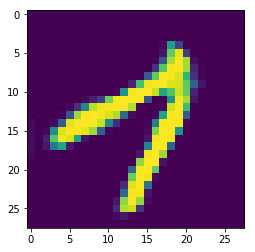

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 9


100%|██████████| 468/468 [00:15<00:00, 30.15it/s]

 D_loss: 0.61717385 G_loss: 1.0073044


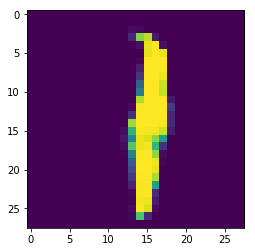

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 10


100%|██████████| 468/468 [00:15<00:00, 30.13it/s]


 D_loss: 0.60423654 G_loss: 1.0733385


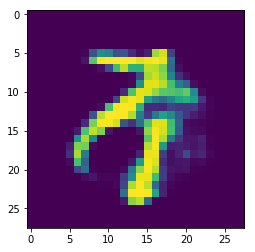

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 11


100%|██████████| 468/468 [00:15<00:00, 30.09it/s]

 D_loss: 0.5996441 G_loss: 0.9662656


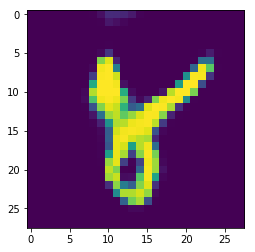

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 12


100%|██████████| 468/468 [00:15<00:00, 30.12it/s]


 D_loss: 0.6012633 G_loss: 0.8986523


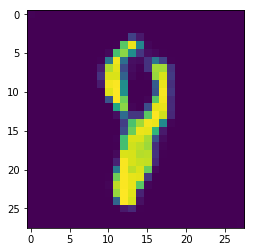

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 13


100%|██████████| 468/468 [00:15<00:00, 30.19it/s]

 D_loss: 0.5952785 G_loss: 1.0273318


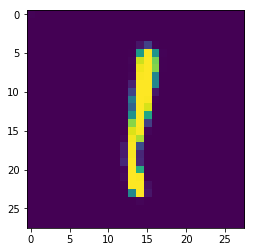

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 14


100%|██████████| 468/468 [00:15<00:00, 30.16it/s]

 D_loss: 0.6188004 G_loss: 0.9221337


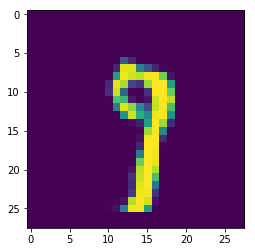

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 15


100%|██████████| 468/468 [00:15<00:00, 30.17it/s]


 D_loss: 0.613905 G_loss: 1.0129814


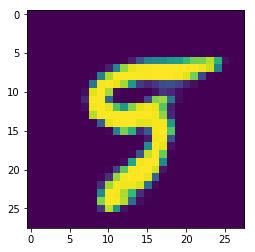

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 16


100%|██████████| 468/468 [00:15<00:00, 30.17it/s]


 D_loss: 0.62731314 G_loss: 1.0398527


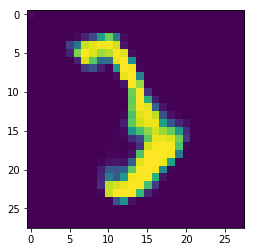

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 17


100%|██████████| 468/468 [00:15<00:00, 30.19it/s]

 D_loss: 0.6247589 G_loss: 1.0524273


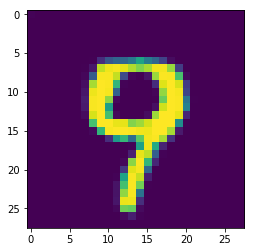

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 18


100%|██████████| 468/468 [00:15<00:00, 30.18it/s]


 D_loss: 0.62653875 G_loss: 0.8681485


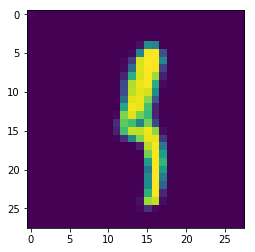

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 19


100%|██████████| 468/468 [00:15<00:00, 30.09it/s]


 D_loss: 0.62713474 G_loss: 1.0085909


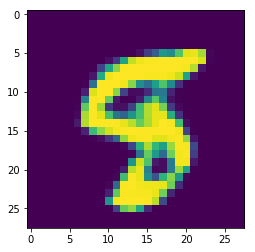

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 20


100%|██████████| 468/468 [00:15<00:00, 30.18it/s]


 D_loss: 0.6707585 G_loss: 1.0206944


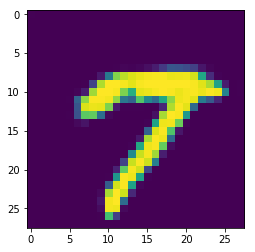

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 21


100%|██████████| 468/468 [00:15<00:00, 30.23it/s]


 D_loss: 0.640312 G_loss: 0.978616


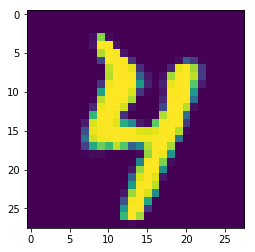

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 22


100%|██████████| 468/468 [00:15<00:00, 30.20it/s]

 D_loss: 0.6332459 G_loss: 0.8911793


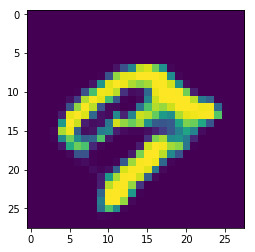

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 23


100%|██████████| 468/468 [00:15<00:00, 30.19it/s]


 D_loss: 0.6443098 G_loss: 0.9531499


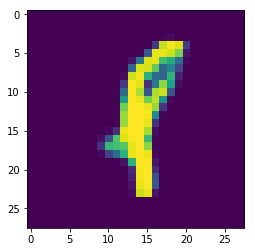

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 24


100%|██████████| 468/468 [00:15<00:00, 30.03it/s]


 D_loss: 0.63291883 G_loss: 1.0092634


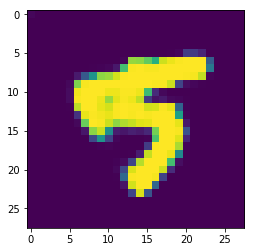

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 25


100%|██████████| 468/468 [00:15<00:00, 30.17it/s]


 D_loss: 0.6300479 G_loss: 0.96351093


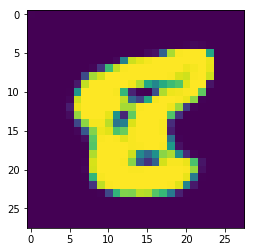

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 26


100%|██████████| 468/468 [00:15<00:00, 29.99it/s]


 D_loss: 0.664648 G_loss: 0.86490625


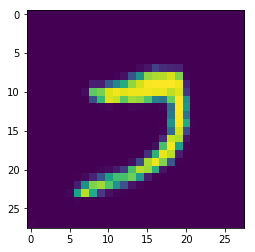

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 27


100%|██████████| 468/468 [00:15<00:00, 29.74it/s]


 D_loss: 0.6548576 G_loss: 0.9349911


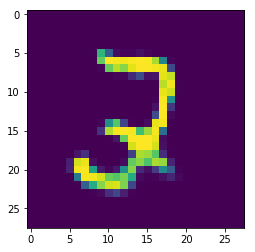

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 28


100%|██████████| 468/468 [00:15<00:00, 30.02it/s]


 D_loss: 0.6516834 G_loss: 0.86874694


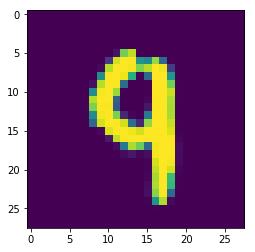

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 29


100%|██████████| 468/468 [00:15<00:00, 29.71it/s]


 D_loss: 0.6221525 G_loss: 0.8862077


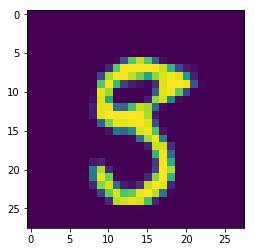

  1%|          | 3/468 [00:00<00:15, 29.99it/s]

 * Epoch: 30


100%|██████████| 468/468 [00:15<00:00, 29.85it/s]


 D_loss: 0.62450564 G_loss: 0.97810435


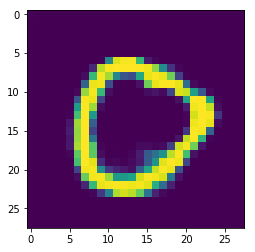

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 31


100%|██████████| 468/468 [00:15<00:00, 29.85it/s]

 D_loss: 0.6405386 G_loss: 1.0896859


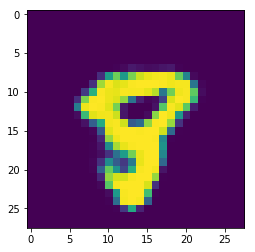

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 32


100%|██████████| 468/468 [00:15<00:00, 30.10it/s]


 D_loss: 0.62425524 G_loss: 0.8085502


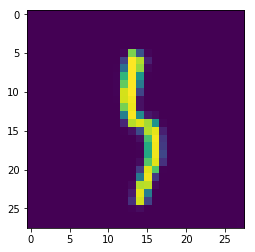

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 33


100%|██████████| 468/468 [00:15<00:00, 29.89it/s]

 D_loss: 0.63167924 G_loss: 0.9274036


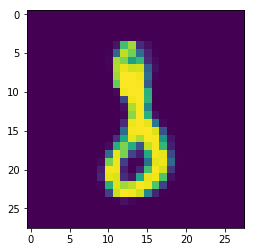

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 34


100%|██████████| 468/468 [00:15<00:00, 30.26it/s]


 D_loss: 0.61715317 G_loss: 0.8205474


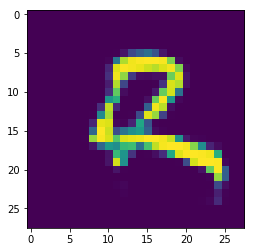

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 35


100%|██████████| 468/468 [00:15<00:00, 29.45it/s]


 D_loss: 0.6249665 G_loss: 0.93921113


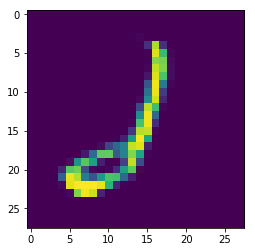

  1%|          | 4/468 [00:00<00:15, 30.61it/s]

 * Epoch: 36


100%|██████████| 468/468 [00:15<00:00, 29.44it/s]


 D_loss: 0.62501335 G_loss: 0.95891815


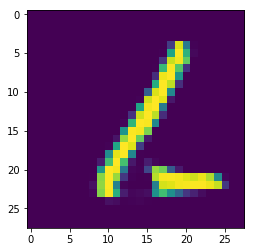

  1%|          | 3/468 [00:00<00:15, 29.78it/s]

 * Epoch: 37


100%|██████████| 468/468 [00:15<00:00, 29.68it/s]

 D_loss: 0.62284917 G_loss: 1.0083106


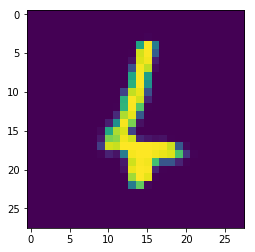

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 38


100%|██████████| 468/468 [00:15<00:00, 29.82it/s]

 D_loss: 0.61531955 G_loss: 0.90677005


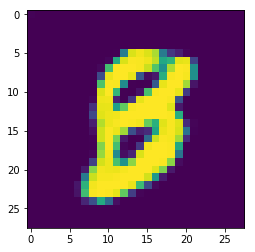

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 39


100%|██████████| 468/468 [00:15<00:00, 29.81it/s]


 D_loss: 0.6383626 G_loss: 0.87807083


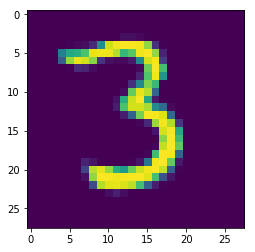

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 40


100%|██████████| 468/468 [00:15<00:00, 29.58it/s]


 D_loss: 0.63791203 G_loss: 0.96693575


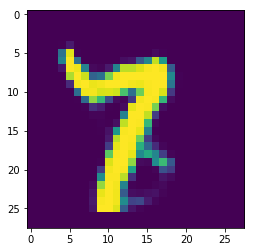

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 41


100%|██████████| 468/468 [00:15<00:00, 30.02it/s]

 D_loss: 0.67691326 G_loss: 0.77448803


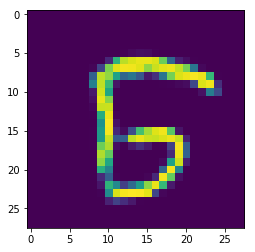

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 42


100%|██████████| 468/468 [00:15<00:00, 29.92it/s]


 D_loss: 0.6327388 G_loss: 1.0353262


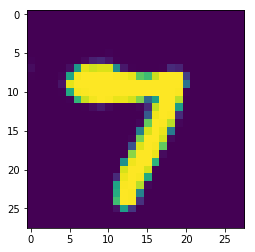

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 43


100%|██████████| 468/468 [00:15<00:00, 30.13it/s]

 D_loss: 0.63296753 G_loss: 0.93090045


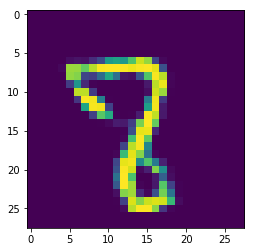

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 44


100%|██████████| 468/468 [00:15<00:00, 29.88it/s]


 D_loss: 0.63855135 G_loss: 0.978529


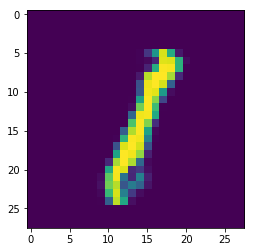

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 45


100%|██████████| 468/468 [00:15<00:00, 30.06it/s]


 D_loss: 0.6340382 G_loss: 0.90716577


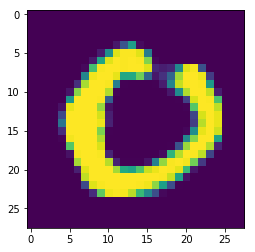

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 46


100%|██████████| 468/468 [00:15<00:00, 29.91it/s]


 D_loss: 0.63543093 G_loss: 0.85571384


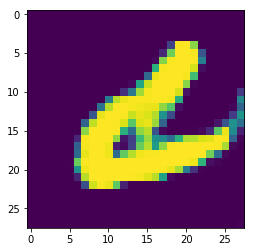

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 47


100%|██████████| 468/468 [00:15<00:00, 29.67it/s]


 D_loss: 0.6457354 G_loss: 0.98337084


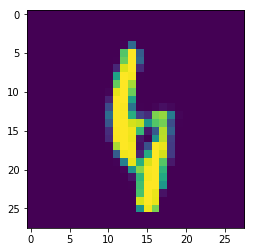

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 48


100%|██████████| 468/468 [00:15<00:00, 29.79it/s]


 D_loss: 0.63404477 G_loss: 0.92824787


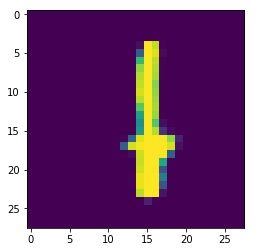

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 49


100%|██████████| 468/468 [00:15<00:00, 30.19it/s]


 D_loss: 0.6193417 G_loss: 0.92374146


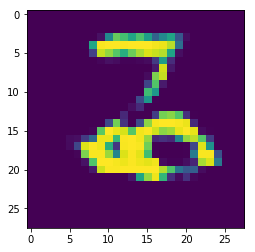

  0%|          | 0/468 [00:00<?, ?it/s]

 * Epoch: 50


100%|██████████| 468/468 [00:15<00:00, 29.97it/s]

 D_loss: 0.62950283 G_loss: 0.8974011


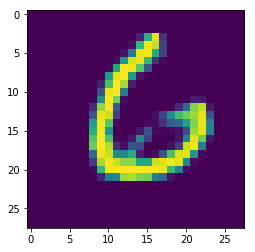

In [12]:
epochs=50
batchSize=128
g_loss_hist = []
d_loss_hist = []
soft_up = 0.9
soft_down = 0.1

no_of_batches = int(x_train.shape[0] / batchSize)

for e in range(epochs):
    
    print(' * Epoch: ' + str(e+1))
    
    for b in tqdm(range(no_of_batches)):
        
        
        noise = np.random.normal(0, 1, size=[batchSize, noise_size]) # noise for generating fake images
        fake_images = generator.predict(noise) # generate fake images
        real_images = x_train[np.random.randint(0, x_train.shape[0], size=batchSize)] # pick random real images

        # Train Discriminator
        discriminator.trainable = True
        
        x = np.concatenate([real_images.reshape(batchSize,28,28,1), fake_images]) 
        y = np.ones(2*batchSize) * soft_down
        y[:batchSize] = soft_up
        
        dloss = discriminator.train_on_batch(x, y)
        
        # Train Ganerator
        discriminator.trainable = False
        y = np.ones(batchSize)
        noise = np.random.normal(0, 1, size=[batchSize, noise_size])
        gloss = gan.train_on_batch(noise, y)

    # epoch results
    print(' D_loss: ' + str(dloss) + ' G_loss: ' + str(gloss))
    d_loss_hist.append(dloss)
    g_loss_hist.append(gloss)

    noise = np.random.normal(0, 1, size=[1, noise_size])
    plt.imshow(generator.predict(noise).reshape(28,28))
    plt.show()
    
    if e % 5 == 10:
        generator.save('models/generator_epoch_' + str(epoch).zfill(5) + '.h5')
        discriminator.save('models/discriminator_epoch_' + str(epoch).zfill(5) + '.h5')

## Evaluation

### Generator Results

In [13]:
def plot_results(real_imgs, fake_imgs):
    
    for real, fake in zip(real_imgs, fake_imgs):
        plt.imshow(real)
        plt.show()
        print(' REAL ')
        print(10*'*')
        
        plt.imshow(fake)
        plt.show()
        print(' FAKE ')
        print(10*'*')

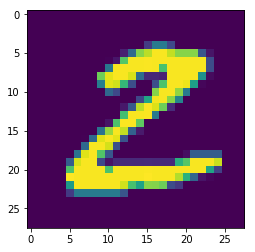

 REAL 
**********


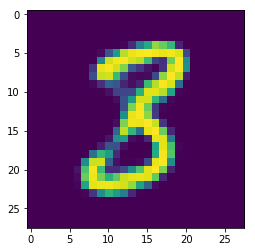

 FAKE 
**********


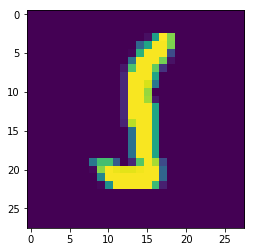

 REAL 
**********


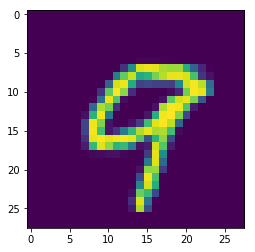

 FAKE 
**********


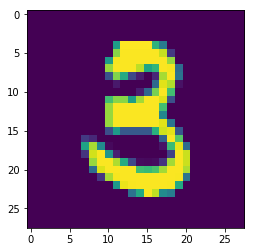

 REAL 
**********


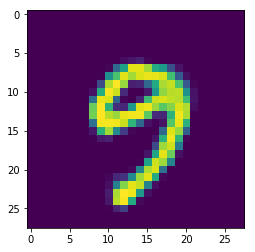

 FAKE 
**********


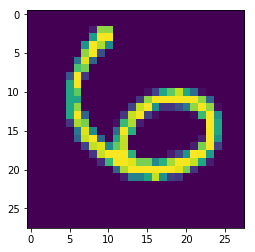

 REAL 
**********


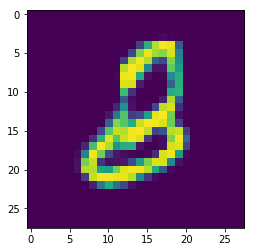

 FAKE 
**********


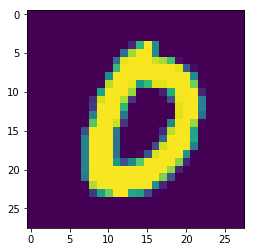

 REAL 
**********


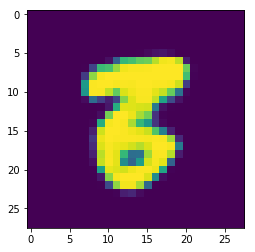

 FAKE 
**********


In [14]:
real_imgs = []
fake_imgs = []
n = 5

for i in range(n):
    
    real_imgs.append(x_train[random.randint(0,x_train.shape[0]-1)])
    
    noise = np.random.uniform(-1,1,size=(1,100))
    fake_imgs.append(generator.predict(noise).reshape(28,28))

plot_results(real_imgs, fake_imgs)

### Discriminator results

In [47]:
confusion_matrix = np.zeros((2,2))

test_batch_size = 100

noise = np.random.normal(0, 1, size=[test_batch_size, noise_size]) 
fake_images = generator.predict(noise)
real_images = x_train[np.random.randint(0, x_train.shape[0], size=test_batch_size)] 

x_test = np.concatenate([real_images.reshape(test_batch_size,28,28,1), fake_images]) 
y_test = np.zeros(2*test_batch_size)
y_test[:test_batch_size] = np.ones(test_batch_size)

for x, y in zip(x_test, y_test):

    result = discriminator.predict(x.reshape(1,28,28,1))
    confusion_matrix[int(y), int(np.round(result[0]).item())] += 1
    
print('Confusion Matrix')
print(confusion_matrix)

Confusion Matrix
[[94.  6.]
 [89. 11.]]
